In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
# بارگیری داده‌ها
data = pd.read_csv('water_consumption.csv')

In [5]:
data.isna().sum()

campus_id         0
meter_id          0
timestamp         0
consumption    1011
dtype: int64

In [6]:
data.dropna(inplace=True)

In [7]:
data.isna().sum()

campus_id      0
meter_id       0
timestamp      0
consumption    0
dtype: int64

In [8]:
# تبدیل ستون timestamp به تاریخ‌های معتبر
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [9]:
# حذف ستون‌های اضافی مانند campus_id و meter_id اگر نیاز دارید
data.drop(['campus_id', 'meter_id'], axis=1, inplace=True)

In [10]:
# تبدیل داده‌ها به آرایه numpy
dataset = data['consumption'].values
dataset = dataset.reshape(-1, 1)

In [11]:
# مقیاس‌بندی داده‌ها
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

In [12]:
# تقسیم داده به داده‌های آموزشی و آزمون
train_size = int(len(dataset_scaled) * 0.8)
test_size = len(dataset_scaled) - train_size
train_data, test_data = dataset_scaled[0:train_size,:], dataset_scaled[train_size:len(dataset_scaled),:]

In [13]:
# تبدیل داده به فرمت مناسب برای LSTM
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [14]:
time_step = 20
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [15]:
# تغییر شکل داده‌ها برای ورودی LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
# ساخت مدل LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

In [17]:
# کامپایل مدل
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# آموزش مدل
history = model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
6101/6101 [==============================] - 104s 16ms/step - loss: 1.6559e-04
Epoch 2/100
6101/6101 [==============================] - 101s 16ms/step - loss: 4.7180e-05
Epoch 3/100
6101/6101 [==============================] - 100s 16ms/step - loss: 4.3776e-05
Epoch 4/100
6101/6101 [==============================] - 100s 16ms/step - loss: 4.2638e-05
Epoch 5/100
6101/6101 [==============================] - 99s 16ms/step - loss: 4.2441e-05
Epoch 6/100
6101/6101 [==============================] - 100s 16ms/step - loss: 4.0874e-05
Epoch 7/100
6101/6101 [==============================] - 98s 16ms/step - loss: 4.0486e-05
Epoch 8/100
6101/6101 [==============================] - 97s 16ms/step - loss: 4.0361e-05
Epoch 9/100
6101/6101 [==============================] - 99s 16ms/step - loss: 3.8677e-05
Epoch 10/100
6101/6101 [==============================] - 100s 16ms/step - loss: 4.0179e-05
Epoch 11/100
6101/6101 [==============================] - 98s 16ms/step - loss: 3.9324e-05
Ep

In [19]:
# پیش‌بینی مصرف در زمان‌های آینده
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1525/1525 [==============================] - 10s 6ms/step


In [20]:
# بازگرداندن داده‌ها به مقیاس اصلی
# بازگرداندن داده‌ها به مقیاس اصلی
train_predict = scaler.inverse_transform(train_predict)
Y_train = Y_train.flatten()
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = Y_test.flatten()
Y_test = scaler.inverse_transform([Y_test])


In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Check for NaN values in Y_train and Y_test
if np.isnan(Y_train).any() or np.isnan(Y_test).any():
    print("Input data contains NaN values. Please handle missing or corrupt data.")
else:
    # Calculate RMSE if there are no NaN values
    train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
    test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))

    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)


Train RMSE: 11.0133173538585
Test RMSE: 4.096543213615265


In [22]:
# محاسبه معیارهای عملکرد مدل مانند MSE یا RMSE
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 11.0133173538585
Test RMSE: 4.096543213615265


In [24]:
history

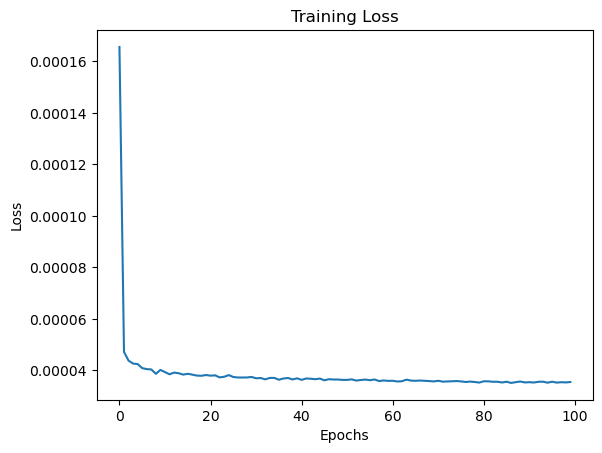

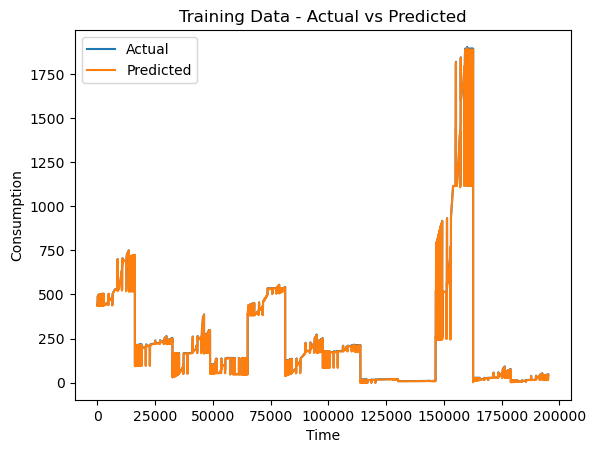

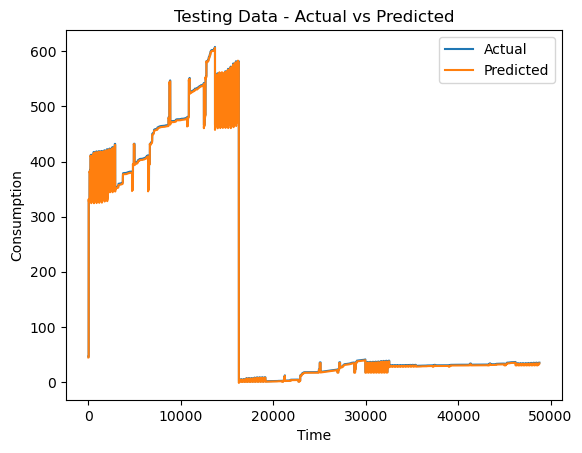

In [27]:
import matplotlib.pyplot as plt

# رسم نمودار یادگیری
loss_values = history.history['loss']
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# رسم نمودار پیش‌بینی واقعی در داده‌های آموزشی
plt.plot(Y_train.flatten(), label='Actual')
plt.plot(train_predict.flatten(), label='Predicted')
plt.title('Training Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

# رسم نمودار پیش‌بینی واقعی در داده‌های آزمون
plt.plot(Y_test.flatten(), label='Actual')
plt.plot(test_predict.flatten(), label='Predicted')
plt.title('Testing Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()



ValueError: x and y must have same first dimension, but have shapes (1,) and (195202,)

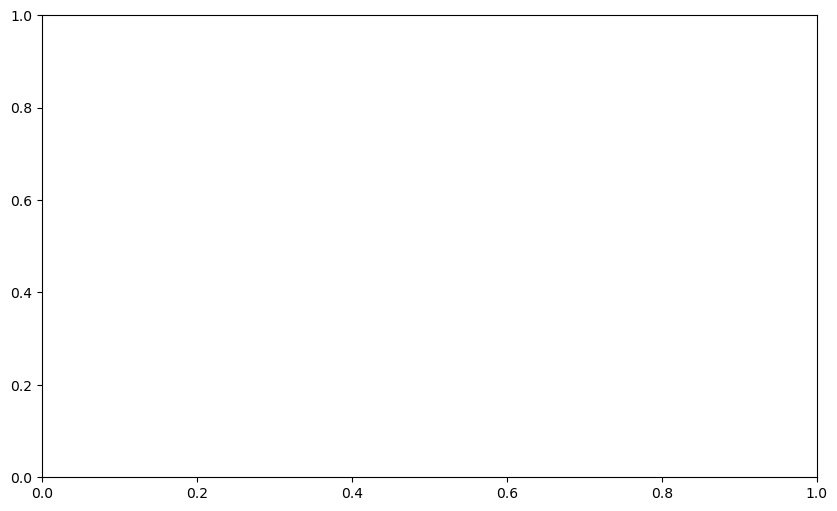

In [31]:
import matplotlib.pyplot as plt

# Plot time series data with predicted values (training set)
plt.figure(figsize=(10, 6))
plt.plot(data.index[:len(Y_train)], Y_train.flatten(), label='Actual')
plt.plot(data.index[:len(Y_train)], train_predict.flatten(), label='Predicted')
plt.title('Training Data - Actual vs Predicted')
plt.xlabel('Date and Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

# Plot time series data with predicted values (testing set)
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(Y_test):], Y_test.flatten(), label='Actual')
plt.plot(data.index[-len(Y_test):], test_predict.flatten(), label='Predicted')
plt.title('Testing Data - Actual vs Predicted')
plt.xlabel('Date and Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()
